In [60]:
import pandas as pd
import numpy as np
import torch
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from scipy.special import softmax
from sklearn.metrics import pairwise
from tqdm import tqdm

from ece_bin import ECE_bin
from CV_pipeline import ECE_bin_CV
from experiments import TCE_experiments, CCE_experiments, unpickle_probs

In [61]:
settings_c10 = [
    ('Cifar10', 'LeNet-5', 'logits/probs_lenet5_c10_logits.p'),
    ('Cifar10', 'Densenet-40', 'logits/probs_densenet40_c10_logits.p'),
    ('Cifar10', 'ResNetWide-32', 'logits/probs_resnet_wide32_c10_logits.p'),
    ('Cifar10', 'Resnet-110', 'logits/probs_resnet110_c10_logits.p'),
    ('Cifar10', 'Resnet-110 SD', 'logits/probs_resnet110_SD_c10_logits.p'),
]
settings_c100 = [
    # ('Cifar100', 'LeNet-5', 'logits/probs_lenet5_c100_logits.p'),
    # ('Cifar100', 'Densenet-40', 'logits/probs_densenet40_c100_logits.p'),
    # ('Cifar100', 'ResNetWide-32', 'logits/probs_resnet_wide32_c100_logits.p'),
    # ('Cifar100', 'Resnet-110', 'logits/probs_resnet110_c100_logits.p'),
    # ('Cifar100', 'Resnet-110 SD', 'logits/probs_resnet110_SD_c100_logits.p'),
]
settings_imgnet = [
    # ('ImageNet', 'DenseNet-161', 'logits/diag_densenet161_imgnet'),
    # ('ImageNet', 'Resnet-152', 'logits/diag_resnet152_imgnet'),
    # ('ImageNet', 'Pnasnet-5', 'logits/diag_pnasnet5_large_imgnet'),
]

In [62]:
exp_results = TCE_experiments(
    settings_c10+settings_c100+settings_imgnet, k_folds_val=5, k_folds_test=1,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [26:38<00:00, 319.69s/it]


In [ ]:
filename = 'results/real_data/TCE_binning_krr_kkrr_kde.pkl'
with open(filename, 'wb') as file:
    pickle.dump(exp_results, file)

In [63]:
filename = 'results/real_data/TCE_binning_krr_kkrr_kde.pkl'
with open(filename, 'rb') as file:
    exp_results = pickle.load(file)
exp_results = pd.DataFrame(exp_results)
exp_results['TCE estimate'] = exp_results['ECE estimate']**.5
exp_results['RMSE'] = exp_results['Val Risk']**.5
exp_results['Estimator'] = exp_results['Type'].replace({
    '15 bins': 'TCE$_2^{15-bins}$',
    'Opt bins': 'TCE$_2^{bins}$',
    'Opt KKRR': 'TCE$_2^{ukkr}$',
    'Opt KRR': 'TCE$_2^{kkr}$',
    'Opt KDE': 'TCE$_2^{kde}$',
})

In [64]:
std_results = []
for index, result in exp_results.iterrows():
    pd_results = pd.DataFrame(result['CV results'])
    pd_results['val_risk'] = pd_results['val_risk']**.5
    pd_results['avg_pred_test'] = pd_results['avg_pred_test']**.5
    if result['Type']=='15 bins':
        val_risk = pd_results[pd_results['n_bins']==15]['val_risk'].mean()
        val_risk_std = pd_results[pd_results['n_bins']==15]['val_risk'].std()
        test_ece_est = pd_results[pd_results['n_bins']==15]['avg_pred_test'].mean()
        test_ece_est_std = pd_results[pd_results['n_bins']==15]['avg_pred_test'].std()
    else:
        if result['Type']=='Opt bins':
            grp_results = pd_results.groupby(['n_bins']).mean()
            grp_results_std = pd_results.groupby(['n_bins']).std()
        elif result['Type']=='Opt KKRR':
            grp_results = pd_results.groupby(['reg_const']).mean()
            grp_results_std = pd_results.groupby(['reg_const']).std()
        elif result['Type']=='Opt KRR':
            grp_results = pd_results.groupby(['reg_const']).mean()
            grp_results_std = pd_results.groupby(['reg_const']).std()
        elif result['Type']=='Opt KDE':
            pd_results['bandwidth'] = torch.Tensor(pd_results['bandwidth'].values.tolist()).numpy()
            grp_results = pd_results.groupby(['bandwidth']).mean()
            grp_results_std = pd_results.groupby(['bandwidth']).std()
        optim = grp_results['val_risk'].argmin()
        val_risk = grp_results.iloc[optim]['val_risk'].item()
        val_risk_std = grp_results_std.iloc[optim]['val_risk'].item()
        test_ece_est = grp_results.iloc[optim]['avg_pred_test'].item()
        test_ece_est_std = grp_results_std.iloc[optim]['avg_pred_test'].item()
        
    std_results += [{
        'Dataset': result['Dataset'],
        'Model': result['Model'],
        'TCE estimate': test_ece_est,
        'TCE estimate STD': test_ece_est_std,
        'Acc': result['Acc'],
        'Type': result['Type'],
        'RMSE': val_risk,
        'RMSE STD': val_risk_std,
        'Runtime': result['Runtime'] if 'Runtime' in result.keys() else None,
    }]

std_results = pd.DataFrame(std_results)
std_results['Estimator'] = std_results['Type'].replace({
    '15 bins': 'TCE$_2^{15-bins}$',
    'Opt bins': 'TCE$_2^{bins}$',
    'Opt KKRR': 'TCE$_2^{ukkr}$',
    'Opt KRR': 'TCE$_2^{kkr}$',
    'Opt KDE': 'TCE$_2^{kde}$',
})

In [65]:
sub_results = std_results[std_results['Dataset']=='Cifar10']

/tmp/ipykernel_27057/3561325050.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)


<Figure size 600x400 with 0 Axes>

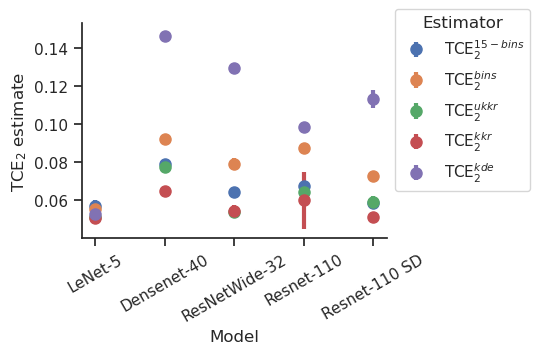

In [43]:
colors = {
    'TCE$_2^{15-bins}$':'tab:blue',
    'TCE$_2^{bins}$':'tab:orange',
    'TCE$_2^{ukkr}$':'tab:green',
    'TCE$_2^{kkr}$':'tab:red',
    'TCE$_2^{kde}$':'tab:purple'
}
dot_size = 8
sns.set(font_scale=1)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(data=sub_results, hue='Estimator', aspect=1.5)
g.map(plt.errorbar, 'Model', 'TCE estimate', 'TCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
g.set(ylabel='TCE$_2$ estimate')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.legend(loc="upper left",bbox_to_anchor=(1,1.1), title='Estimator')
g.savefig("Plots/TCE_cif10_binning_krr_kkrr_kde.png", bbox_inches='tight', dpi=1000);

In [6]:
n_signif_digs = 2
sub_results.loc[:,'RMSE'] = np.round(sub_results['RMSE']*100, n_signif_digs)
sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)
result_table = pd.pivot_table(
    sub_results[['Model', 'RMSE', 'Estimator']],
    values='RMSE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table_std = pd.pivot_table(
    sub_results[['Model', 'RMSE STE', 'Estimator']],
    values='RMSE STE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
columns_titles = ['LeNet-5', 'Densenet-40', 'ResNetWide-32', 'Resnet-110',
       'Resnet-110 SD']
result_table=result_table.reindex(columns=columns_titles)
print(result_table.to_latex())

\begin{tabular}{llllll}
\toprule
Model & LeNet-5 & Densenet-40 & ResNetWide-32 & Resnet-110 & Resnet-110 SD \\
Estimator &  &  &  &  &  \\
\midrule
TCE$_2^{15-bins}$ & 14.96 $\pm$ 0.31 & 6.14 $\pm$ 0.12 & 5.03 $\pm$ 0.2 & 5.4 $\pm$ 0.24 & 4.73 $\pm$ 0.25 \\
TCE$_2^{bins}$ & 14.96 $\pm$ 0.31 & 6.12 $\pm$ 0.12 & 5.03 $\pm$ 0.2 & 5.39 $\pm$ 0.23 & 4.72 $\pm$ 0.25 \\
TCE$_2^{kde}$ & 14.98 $\pm$ 0.31 & 13.7 $\pm$ 0.27 & 12.31 $\pm$ 0.65 & 7.46 $\pm$ 0.35 & 10.65 $\pm$ 0.58 \\
TCE$_2^{kkr}$ & 14.96 $\pm$ 0.31 & 6.13 $\pm$ 0.12 & 5.03 $\pm$ 0.2 & 5.39 $\pm$ 0.24 & 4.72 $\pm$ 0.25 \\
TCE$_2^{ukkr}$ & 14.96 $\pm$ 0.31 & 6.11 $\pm$ 0.12 & 5.03 $\pm$ 0.2 & 5.38 $\pm$ 0.24 & 4.72 $\pm$ 0.25 \\
\bottomrule
\end{tabular}



<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/43952719.py:18: SyntaxWarning: invalid escape sequence '\p'
  result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/43952719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)


[Text(0, 0.5, 'Runtime [s]'), Text(0.5, 0, 'Estimator')]

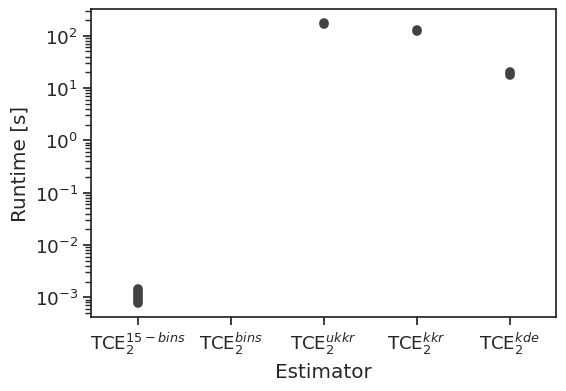

In [87]:
# runtime

sns.set(font_scale=1.2)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
#g = sns.barplot(data=sub_results[sub_results['Estimator'].isin(['TCE$_2^{bins}$', 'TCE$_2^{15-bins}$'])], x='Estimator', y='Runtime', log_scale=True, err_kws={'linewidth': 7})
g = sns.barplot(data=sub_results, x='Estimator', y='Runtime', log_scale=True, err_kws={'linewidth': 7})
g.set(ylabel='Runtime [s]', xlabel='Estimator')
#sns.barplot(data=exp_results, x='Type', y='Runtime')
#plt.errorbar(data=exp_results, x='Type', y='Runtime', fmt='o', elinewidth=3, markersize=dot_size)
# g = sns.FacetGrid(data=sub_results, hue='Estimator', aspect=1.5)
# g.map(plt.errorbar, 'Model', 'TCE estimate', 'TCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
# g.set(ylabel='TCE$_2$ estimate')
# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
# plt.legend(loc="upper left",bbox_to_anchor=(1,1.1), title='Estimator')
g.figure.savefig("Plots/TCE_cif10_runtime.png", bbox_inches='tight', dpi=1000);

In [44]:
sub_results = std_results[std_results['Dataset']=='Cifar100']

/tmp/ipykernel_27057/516371391.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)


<Figure size 600x400 with 0 Axes>

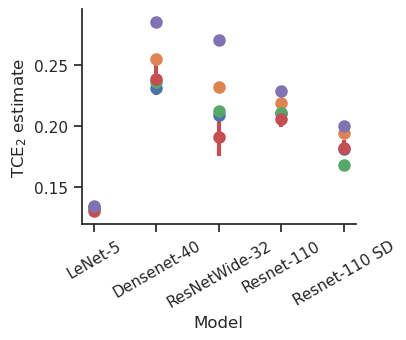

In [45]:
colors = {
    'TCE$_2^{15-bins}$':'tab:blue',
    'TCE$_2^{bins}$':'tab:orange',
    'TCE$_2^{ukkr}$':'tab:green',
    'TCE$_2^{kkr}$':'tab:red',
    'TCE$_2^{kde}$':'tab:purple'
}
dot_size = 8
sns.set(font_scale=1)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(data=sub_results, hue='Estimator', aspect=1.4)
g.map(plt.errorbar, 'Model', 'TCE estimate', 'TCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
g.set(ylabel='TCE$_2$ estimate')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
g.savefig("Plots/TCE_cif100_binning_krr_kkrr_kde.png", bbox_inches='tight', dpi=1000);

In [8]:
n_signif_digs = 2
sub_results.loc[:,'RMSE'] = np.round(sub_results['RMSE']*100, n_signif_digs)
sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)
result_table = pd.pivot_table(
    sub_results[['Model', 'RMSE', 'Estimator']],
    values='RMSE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table_std = pd.pivot_table(
    sub_results[['Model', 'RMSE STE', 'Estimator']],
    values='RMSE STE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
columns_titles = ['LeNet-5', 'Densenet-40', 'ResNetWide-32', 'Resnet-110',
       'Resnet-110 SD']
result_table=result_table.reindex(columns=columns_titles)
print(result_table.to_latex())

\begin{tabular}{llllll}
\toprule
Model & LeNet-5 & Densenet-40 & ResNetWide-32 & Resnet-110 & Resnet-110 SD \\
Estimator &  &  &  &  &  \\
\midrule
TCE$_2^{15-bins}$ & 18.51 $\pm$ 0.16 & 20.66 $\pm$ 0.4 & 18.4 $\pm$ 0.19 & 18.67 $\pm$ 0.43 & 17.18 $\pm$ 0.2 \\
TCE$_2^{bins}$ & 18.5 $\pm$ 0.16 & 20.43 $\pm$ 0.38 & 18.24 $\pm$ 0.17 & 18.61 $\pm$ 0.42 & 17.11 $\pm$ 0.2 \\
TCE$_2^{kde}$ & 18.5 $\pm$ 0.16 & 23.74 $\pm$ 0.41 & 23.28 $\pm$ 0.18 & 19.69 $\pm$ 0.47 & 18.21 $\pm$ 0.19 \\
TCE$_2^{kkr}$ & 18.5 $\pm$ 0.16 & 20.52 $\pm$ 0.39 & 18.29 $\pm$ 0.18 & 18.59 $\pm$ 0.42 & 17.11 $\pm$ 0.2 \\
TCE$_2^{ukkr}$ & 18.5 $\pm$ 0.16 & 20.51 $\pm$ 0.4 & 18.28 $\pm$ 0.18 & 18.61 $\pm$ 0.43 & 17.12 $\pm$ 0.21 \\
\bottomrule
\end{tabular}



<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/43952719.py:18: SyntaxWarning: invalid escape sequence '\p'
  result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/43952719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)


In [46]:
sub_results = std_results[std_results['Dataset']=='ImageNet']

/tmp/ipykernel_27057/4175110985.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)


<Figure size 600x400 with 0 Axes>

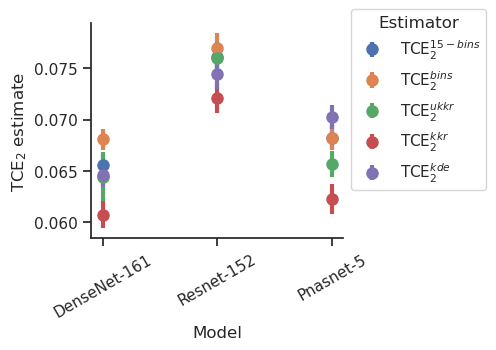

In [47]:
colors = {
    'TCE$_2^{15-bins}$':'tab:blue',
    'TCE$_2^{bins}$':'tab:orange',
    'TCE$_2^{ukkr}$':'tab:green',
    'TCE$_2^{kkr}$':'tab:red',
    'TCE$_2^{kde}$':'tab:purple'
}
dot_size = 8
sns.set(font_scale=1)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(data=sub_results, hue='Estimator', aspect=1.3)
g.map(plt.errorbar, 'Model', 'TCE estimate', 'TCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
g.set(ylabel='TCE$_2$ estimate')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.legend(loc="upper left",bbox_to_anchor=(1,1.1), title='Estimator')
g.savefig("Plots/TCE_Imgnet_binning_krr_kkrr_kde.png", bbox_inches='tight', dpi=1000);

In [10]:
n_signif_digs = 2
sub_results.loc[:,'RMSE'] = np.round(sub_results['RMSE']*100, n_signif_digs)
sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)
result_table = pd.pivot_table(
    sub_results[['Model', 'RMSE', 'Estimator']],
    values='RMSE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table_std = pd.pivot_table(
    sub_results[['Model', 'RMSE STE', 'Estimator']],
    values='RMSE STE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
columns_titles = ['DenseNet-161', 'Resnet-152', 'Pnasnet-5']
result_table=result_table.reindex(columns=columns_titles)
print(result_table.to_latex())

\begin{tabular}{llll}
\toprule
Model & DenseNet-161 & Resnet-152 & Pnasnet-5 \\
Estimator &  &  &  \\
\midrule
TCE$_2^{15-bins}$ & 12.17 $\pm$ 0.16 & 12.58 $\pm$ 0.14 & 10.63 $\pm$ 0.16 \\
TCE$_2^{bins}$ & 12.17 $\pm$ 0.16 & 12.57 $\pm$ 0.14 & 10.63 $\pm$ 0.16 \\
TCE$_2^{kde}$ & 12.31 $\pm$ 0.17 & 12.77 $\pm$ 0.14 & 10.63 $\pm$ 0.16 \\
TCE$_2^{kkr}$ & 12.17 $\pm$ 0.16 & 12.57 $\pm$ 0.14 & 10.63 $\pm$ 0.16 \\
TCE$_2^{ukkr}$ & 12.17 $\pm$ 0.16 & 12.57 $\pm$ 0.14 & 10.63 $\pm$ 0.16 \\
\bottomrule
\end{tabular}



<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/744527313.py:18: SyntaxWarning: invalid escape sequence '\p'
  result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/744527313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)


In [3]:
###########################
### CANONICAL CALIBRATION
###########################

In [ ]:
# exp_results = CCE_experiments(
#     settings_c10+settings_c100+settings_imgnet, k_folds_val=5, k_folds_test=1, estimators=['kkrr', 'krr', 'kde']
# )
# filename = 'results/real_data/CCE_krr_kkrr_kde_imgnet.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(exp_results, file)

  0%|                                                                                                                  | 0/3 [00:00<?, ?it/s]

In [3]:
filename = 'results/real_data/CCE_krr_kkrr_imgnet.pkl'
with open(filename, 'rb') as file:
    exp_results = pickle.load(file)
exp_results = pd.DataFrame(exp_results)
exp_results['CCE estimate'] = exp_results['ECE estimate']**.5
exp_results['RMSE'] = exp_results['Val Risk']**.5
#exp_results

In [48]:
filename = 'results/real_data/CCE_krr_kkrr_kde.pkl'
with open(filename, 'rb') as file:
    exp_results_ = pickle.load(file)
exp_results = pd.DataFrame(exp_results_)
exp_results['CCE estimate'] = exp_results['ECE estimate']**.5
exp_results['RMSE'] = exp_results['Val Risk']**.5
exp_results['Estimator'] = exp_results['Type'].replace({
    'Opt KKRR': 'CCE$_2^{ukkr}$',
    'Opt KRR': 'CCE$_2^{kkr}$',
    'Opt KDE': 'CCE$_2^{kde}$',
})

In [49]:
std_results = []
for index, result in exp_results.iterrows():
    pd_results = pd.DataFrame(result['CV results'])
    pd_results['val_risk'] = pd_results['val_risk']**.5
    pd_results['avg_pred_test'] = pd_results['avg_pred_test']**.5
    if result['Type']=='Opt KKRR':
        grp_results = pd_results.groupby(['reg_const']).mean()
        grp_results_std = pd_results.groupby(['reg_const']).std()
    elif result['Type']=='Opt KRR':
        grp_results = pd_results.groupby(['reg_const']).mean()
        grp_results_std = pd_results.groupby(['reg_const']).std()
    elif result['Type']=='Opt KDE':
        pd_results['bandwidth'] = torch.Tensor(pd_results['bandwidth'].values.tolist()).numpy()
        grp_results = pd_results.groupby(['bandwidth']).mean()
        grp_results_std = pd_results.groupby(['bandwidth']).std()
    optim = grp_results['val_risk'].argmin()
    val_risk = grp_results.iloc[optim]['val_risk'].item()
    val_risk_std = grp_results_std.iloc[optim]['val_risk'].item()
    test_ece_est = grp_results.iloc[optim]['avg_pred_test'].item()
    test_ece_est_std = grp_results_std.iloc[optim]['avg_pred_test'].item()
    
    std_results += [{
        'Dataset': result['Dataset'],
        'Model': result['Model'],
        'CCE estimate': test_ece_est,
        'CCE estimate STD': test_ece_est_std,
        'Type': result['Type'],
        'RMSE': val_risk,
        'RMSE STD': val_risk_std,
    }]

std_results = pd.DataFrame(std_results)
std_results['Estimator'] = std_results['Type'].replace({
    'Opt KKRR': 'CCE$_2^{ukkr}$',
    'Opt KRR': 'CCE$_2^{kkr}$',
    'Opt KDE': 'CCE$_2^{kde}$',
})

In [57]:
sub_results = std_results[std_results['Dataset']=='Cifar10']

/tmp/ipykernel_27057/3222185634.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)


<Figure size 600x400 with 0 Axes>

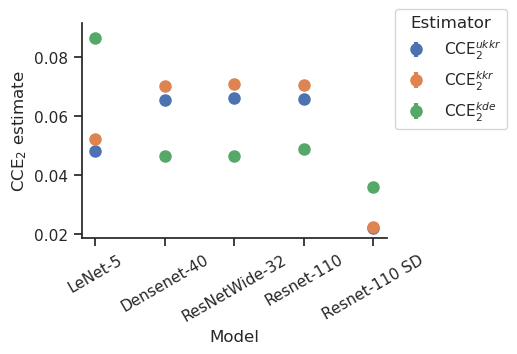

In [58]:
colors = {
    'CCE$_2^{ukkr}$':'tab:green',
    'CCE$_2^{kkr}$':'tab:red',
    'CCE$_2^{kde}$':'tab:purple'
}
dot_size = 8
sns.set(font_scale=1)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(data=sub_results, hue='Estimator', aspect=1.5)
g.map(plt.errorbar, 'Model', 'CCE estimate', 'CCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
g.set(ylabel='CCE$_2$ estimate')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.legend(loc="upper left",bbox_to_anchor=(1,1.1), title='Estimator')
g.savefig("Plots/CCE_cif10_krr_kkrr_kde.png", bbox_inches='tight', dpi=1000);

In [14]:
n_signif_digs = 2
sub_results.loc[:,'RMSE'] = np.round(sub_results['RMSE']*100, n_signif_digs)
sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)

result_table = pd.pivot_table(
    sub_results[['Model', 'RMSE', 'Estimator']],
    values='RMSE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table_std = pd.pivot_table(
    sub_results[['Model', 'RMSE STE', 'Estimator']],
    values='RMSE STE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
columns_titles = ['LeNet-5', 'Densenet-40', 'ResNetWide-32', 'Resnet-110',
       'Resnet-110 SD']
result_table=result_table.reindex(columns=columns_titles)
print(result_table.to_latex())

\begin{tabular}{llllll}
\toprule
Model & LeNet-5 & Densenet-40 & ResNetWide-32 & Resnet-110 & Resnet-110 SD \\
Estimator &  &  &  &  &  \\
\midrule
CCE$_2^{kde}$ & 13.53 $\pm$ 0.27 & 5.13 $\pm$ 0.13 & 4.22 $\pm$ 0.16 & 4.46 $\pm$ 0.14 & 3.89 $\pm$ 0.2 \\
CCE$_2^{kkr}$ & 13.53 $\pm$ 0.27 & 5.13 $\pm$ 0.13 & 4.22 $\pm$ 0.16 & 4.47 $\pm$ 0.14 & 3.89 $\pm$ 0.2 \\
CCE$_2^{ukkr}$ & 13.53 $\pm$ 0.27 & 5.13 $\pm$ 0.13 & 4.22 $\pm$ 0.16 & 4.47 $\pm$ 0.14 & 3.89 $\pm$ 0.2 \\
\bottomrule
\end{tabular}



<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/502546554.py:19: SyntaxWarning: invalid escape sequence '\p'
  result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/502546554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)


In [55]:
sub_results = std_results[std_results['Dataset']=='Cifar100']

/tmp/ipykernel_27057/3437716716.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)


<Figure size 600x400 with 0 Axes>

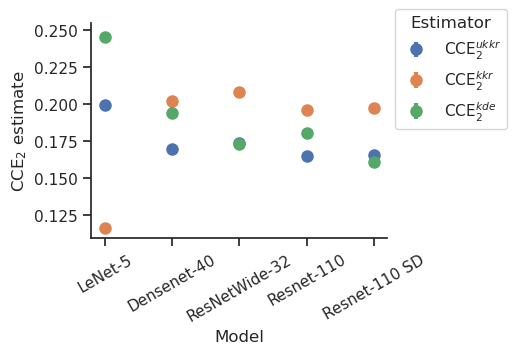

In [56]:
colors = {
    'CCE$_2^{ukkr}$':'tab:green',
    'CCE$_2^{kkr}$':'tab:red',
    'CCE$_2^{kde}$':'tab:purple'
}
dot_size = 8
sns.set(font_scale=1)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(data=sub_results, hue='Estimator', aspect=1.5)
g.map(plt.errorbar, 'Model', 'CCE estimate', 'CCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
g.set(ylabel='CCE$_2$ estimate')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.legend(loc="upper left",bbox_to_anchor=(1,1.1), title='Estimator')
g.savefig("Plots/CCE_cif100_krr_kkrr_kde.png", bbox_inches='tight', dpi=1000);

In [16]:
n_signif_digs = 2
sub_results.loc[:,'RMSE'] = np.round(sub_results['RMSE']*100, n_signif_digs)
sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)

result_table = pd.pivot_table(
    sub_results[['Model', 'RMSE', 'Estimator']],
    values='RMSE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table_std = pd.pivot_table(
    sub_results[['Model', 'RMSE STE', 'Estimator']],
    values='RMSE STE',
    index=['Estimator'],
    columns=['Model'],
    aggfunc="sum"
)
result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
columns_titles = ['LeNet-5', 'Densenet-40', 'ResNetWide-32', 'Resnet-110',
       'Resnet-110 SD']
result_table=result_table.reindex(columns=columns_titles)
print(result_table.to_latex())

\begin{tabular}{llllll}
\toprule
Model & LeNet-5 & Densenet-40 & ResNetWide-32 & Resnet-110 & Resnet-110 SD \\
Estimator &  &  &  &  &  \\
\midrule
CCE$_2^{kde}$ & 8.38 $\pm$ 0.06 & 5.61 $\pm$ 0.09 & 4.98 $\pm$ 0.05 & 5.14 $\pm$ 0.1 & 4.79 $\pm$ 0.03 \\
CCE$_2^{kkr}$ & 8.36 $\pm$ 0.06 & 5.56 $\pm$ 0.09 & 5.0 $\pm$ 0.05 & 5.16 $\pm$ 0.1 & 4.8 $\pm$ 0.03 \\
CCE$_2^{ukkr}$ & 8.35 $\pm$ 0.06 & 5.56 $\pm$ 0.09 & 5.01 $\pm$ 0.05 & 5.16 $\pm$ 0.1 & 4.8 $\pm$ 0.02 \\
\bottomrule
\end{tabular}



<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/502546554.py:19: SyntaxWarning: invalid escape sequence '\p'
  result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_80635/502546554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_results.loc[:,'RMSE STE'] = np.round(sub_results['RMSE STD']*100/(5**.5), n_signif_digs)
